<a href="https://colab.research.google.com/github/cerezamo/NLP_brouillon/blob/master/Camembert_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CamemBERT classification model 


## Set up colab GPU and installing main packages

In [0]:
# If you have the documents in your drive already otherwise just drag 'medium_df_desequ.csv' and 'funct.py' in the file section
import os 
os.getcwd()
from google.colab import drive 
drive.mount('/content/gdrive')

In [11]:
# First you should go in 'Edit' -> 'Notebook settings' -> Add device GPU
import tensorflow as tf

# GPU device name.
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

ERROR! Session/line number was not unique in database. History logging moved to new session 59


We now can tell torch that one GPU is available 

In [12]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [13]:
!nvidia-smi

Sat Apr  4 09:34:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  



**Please check GPU capacity** that you were given. You might want to reduce the batch size further in the code.  Typically if you were given 8Go memory GPU (Tesla P4) you should set the batch size to 2 not more ! 

We now install the Hugging Face library transformers. You can find all the documentation of hugging face in their Github : https://github.com/huggingface/transformers  

In [14]:
! pip install transformers 

## Loading our corpus and preparing samples 

In [0]:
# We keep the same seed value all along this notebook in order to be able to replicate the results 
seed_val = 2003

In [201]:
# Import medium_df_desq in "files" (on the left) this can take some time ! 
import pandas as pd
import numpy as np

# Load the dataset into a pandas dataframe.
df=pd.read_csv('medium_df_deseq.csv',encoding='utf-8')

# Shuffle the date
df=df.sample(frac=1,random_state=seed_val).reset_index(drop=True)

# Some of the speeches are interviews (wrongly classified in the website) we try to delete most of them  
df=df[~df.Texte.str.startswith("Q-")]
df=df[~df.Texte.str.startswith("R-")]
df=df[df.Id!=169898] # FOr some reason a problem on this text occured for preprocessing

# Normalization of the labels [0,1] instead of [1,2] (0 = men, 1 = women)
df.sexe=df.sexe.replace(1,0)
df.sexe=df.sexe.replace(2,1)

# We keep only variables of interest 
df=df[['Id','Titre','Theme','Prenom','Nom','Date','Tags','Texte','sexe']]

# For the cleaning part we will just remove urls, parenthesis and double spacing if any 
import re
def cleaning_stuff(text):
    text = re.sub(r" \(.*?\)", '', text, flags=re.MULTILINE)
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    text = text.replace('(',' ')
    text = text.replace(')',' ')
    text = text.replace('.  ','. ')
    text = text.replace('  ','')
    text=text.replace(" :'","") 
    text = text.strip()
    text = text.replace("\'","'")
    return text 

df['Texte']=df.Texte.apply(cleaning_stuff)
df=df[df.Texte!='']

df = df[~df.Titre.str.startswith('Déclaration conjointe')]
# This is a sample of our dataset
df.head(5)

,Id,Titre,Theme,Prenom,Nom,Date,Tags,Texte,sexe
0,160153,"Déclaration de Mme Michèle Alliot-Marie, minis...",Société,Michèle,Alliot-Marie,2006-01-23T12:00:00Z,"Sécurité,Gendarmerie",C'est une grande satisfaction d'être aujourd'h...,1
1,149333,"Déclaration de M. François Baroin, ministre de...",Institutions,François,Baroin,2005-06-11T12:00:00Z,"Citoyenneté - Elections,Parti politique",Mes premiers mots iront vers nos amis d'Outre-...,0
2,178463,"Déclaration de M. Xavier Darcos, ministre du t...",NaN,Xavier,Darcos,2010-01-12T12:00:00Z,NaN,"Comme vous le savez, après la réforme engagée ...",0
3,180716,"Déclaration de Mme Nathalie Kosciusko-Morizet,...",Economie,Nathalie,Kosciusko-Morizet,2010-12-03T12:00:00Z,"Vie économique,Tourisme","Messieurs les présidents,Mesdames, Messieurs,J...",1
4,153024,"Déclaration de M. Jack Lang, ministre de l'édu...",Société,Jack,Lang,2000-11-22T12:00:00Z,"Sciences - Numérique - I. A.,Economie numériqu...",Je suis heureux de voir que le salon de l'éduc...,0


In [202]:
print(df.Texte[200])

Messieurs les Ministres,Messieurs les Parlementaires,Monsieur l'Ambassadeur, Madame,Mes chers compatriotes, C'est une joie pour moi, les membres du gouvernement, les personnalités qui m'accompagnent, et pour ma femme bien sûr, de venir vous saluer en cette résidence de France où l'ambassadeur et son épouse ont bien voulu nous réunir. Je les en remercie chaleureusement.Au lendemain de mon arrivée à Tokyo, je suis particulièrement heureux de rencontrer ceux qui, chaque jour, incarnent et animent avec dynamisme et conviction la présence de la France au Japon. Vous représentez la continuité de la présence française au Japon, son passé et son avenir. Votre doyenne vient de fêter ses 102 ans. Elle s'est établie au Japon il y a 70 ans au service des plus démunis. Votre plus jeune membre est né il y a quelques semaines. Notre compatriote, M. Marc Dunoyer, reçoit cette année le prix du Commerce international décerné par le Premier ministre du Japon sur proposition du ministère du Commerce inter

**We propose 3 samples to train our model :**


**1.   Unbalanced sample**

We take the raw data without any further treatment.

**2.   Balanced sample**

The second option consists in deleting randomly part of male speeches in order to get a balanced sample. Indeed, in the case of unbalanced sample our model could decide to classify all speakers in the male category which would lead to a 0.75 accuracy in our case study. In order to avoid this we feed the model with the same proportions of male and female speakers. Other kind of treatments exist to deal with unbalanced sample. This one is the simpliest one and we could argue that there is a possibility that the deleted sample contains important information that we therefore miss. However we believe that in our case this is not a big issue. Our unbalanced sample is quite large for both female and male.

**3. Balanced and splitted sample**

The third option is a response to the max length constraint of BERT models. Our text samples are big and contain much more tokens than the 512 limit. In the first two options we decide to feed the model with the 512 first tokens and thus we delete the remaining tokens. In this third option we cut the text into x parts containing 500 tokens each. All parts of the speech will serve to feed the model. Through this technique we do not loose potential important informations at the end of the text. A lot of other techniques have been employed such as hierarchical transformers (see our latex for reference). We decide to stick to this method in this project but it is an obvious improvment that could be added here. 



In [0]:
def unbalanced_preprocess(df):
  ''' 
  This function just takes our unbalanced dataset and prints relevant informations
  '''

  df_unbalanced=df

  # Reports the number of speeches in the corpus.
  print('Number of text in the unbalanced corpus : {0:.2f}\n'.format(df_unbalanced.shape[0]))

  # Reports the percentage of women in the sample 
  prop = (len(df_unbalanced[df_unbalanced.sexe==1])/len(df_unbalanced))*100
  print('Percentage of women in the unbalanced corpus : {0:.2f}\n'.format(prop))

  return df_unbalanced

In [204]:
df_unbalanced = unbalanced_preprocess(df) 

Number of text in the unbalanced corpus : 4977.00

Percentage of women in the unbalanced corpus : 25.12



In [0]:
def balanced_preprocess(df,seed_val,frac_val):
  ''' 
  This function transforms our unbalanced dataset by deleting male speeches

  Input : 
          df : dataframe
          frac_val : fraction of the sample we want (this is mainly here for testing if you want to train your model with less data)

  Output : 
          df_balanced : A balanced version of our dataset with the same proportion of men and women
  '''

  from sklearn.model_selection import train_test_split

  # Let's take a balanced sample 
  df_m = df.loc[df['sexe'] == 0]
  df_f = df.loc[df['sexe'] == 1] 
  df_m = df_m[0:len(df_f)]
  df = df_f.append(df_m)

  #Shuffle the data and taking half of the sample in order not to have to many data compared to the other samples 
  df_balanced=df.sample(frac=frac_val,random_state=seed_val).reset_index()

  # Reports the number of speeches in the corpus.
  print('Number of text in this corpus : {0:.2f}\n'.format(df_balanced.shape[0]))

  # Reports the percentage of women in the sample 
  prop = (len(df_balanced[df_balanced.sexe==1])/len(df_balanced))*100
  print('Percentage of women in the balanced corpus : {0:.2f}\n'.format(prop))

  return df_balanced



In [206]:
df_balanced = balanced_preprocess(df,seed_val,frac_val=1)

Number of text in this corpus : 2500.00

Percentage of women in the balanced corpus : 50.00



In [0]:
import pandas as pd
def sent_detector_mano(x):
    """
        Détection de phrase à la main.
        Input : document
        Output : liste de phrases
        Problème avec les phrases finissant par : entrainant souvent une liste. 
        De même avec ;. Tentative réalisée
        
    """
    lst =[]
    phrase = []
    i = 0
    for caractere in x: 
        if not (caractere == ' ' and len(phrase) == 0) :
            phrase.append(caractere)
        if caractere in '?!.:;':
            if caractere == ':':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            if caractere == ';':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            elif phrase != '.' or phrase != '?' or phrase != '!':
                lst.append(''.join(phrase))
                phrase = []
        i+=1
    return lst
def split_document_to_limit(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = []
    for token in row.Texte.split(' '):
      if len(phrase) < MAX_TOKENS:
        phrase.append(token)
      else:
        lst += [(identifiant,label,' '.join(phrase),len(phrase))]
        phrase = []
    if len(phrase)>1:
      lst += [(identifiant,label,' '.join(phrase),len(phrase))]
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])
def split_document_to_limit_phrases(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = ''
    for phrases in sent_detector_mano(row.Texte):
      if len(phrase.split(' ')) + len(phrases.split(' ')) < MAX_TOKENS:
        phrase+= " " + phrases
      else:
        lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
        phrase = ''
    lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
    phrase = ''
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])

In [0]:
def  balanced_splitted(df,seed_val,frac_val,max_tokens):
  # Let's take a balanced sample 
  df_m = df.loc[df['sexe'] == 0]
  df_f = df.loc[df['sexe'] == 1] 
  df_m = df_m[0:len(df_f)]
  df = df_f.append(df_m)


  df=df[df.Texte!='']

  df=split_document_to_limit_phrases(max_tokens,df)
 
  df=df[df.Texte!='']

  df_balanced_split=df.sample(frac=frac_val,random_state=seed_val).reset_index()

  # Report the number of speeches in the corpus.
  print('Number of text in this balanced splitted corpus : {:,}\n'.format(df_balanced_split.shape[0]))
  prop = (len(df_balanced_split[df_balanced_split.sexe==1])/len(df_balanced_split))*100
  print('Proportions of women in the balanced splitted corpus : {}\n'.format(prop))

  return df_balanced_split

In [212]:
df_balanced_split = balanced_splitted(df,seed_val,frac_val=1,max_tokens=450)

Number of text in this balanced splitted corpus : 11,161

Proportions of women in the balanced splitted corpus : 50.22847415106173



## Tokenization and preparing to feed CamemBERT

### Loading the Camembert Tokenizer

In [0]:
# Import Camembert tokenizer
from transformers import CamembertTokenizer
# We choose a right padding side for the moment and we will test for a left padding side on a second stage
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right') #left

In [214]:
# Print the original text.
print(' Original: ', df.Texte[0])

# Print the text split into tokens.
print('Tokenized: ', tokenizer.tokenize(df.Texte[0]))

# Print the text mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.Texte[0])))

 Original:  C'est une grande satisfaction d'être aujourd'hui à Vicenza, pour ce qui est, j'en suis convaincue, une grande étape de la construction de la défense européenne.Avec les progrès spectaculaires de la politique européenne de sécurité et de défense ces dernières années, la sécurité de l'Europe est plus que jamais la responsabilité des Européens. L'Union européenne a également plus que jamais vocation à jouer un rôle majeur dans la résolution des crises internationales.Pour assumer ce rôle, l'Europe se doit de disposer d'instruments adaptés, réactifs, lui permettant d'intervenir à tous les stades d'évolution d'une crise.C'est parce qu'il me paraissait essentiel de donner aux Européens cette capacité, que j'ai proposé à mes homologues la création de la Force de Gendarmerie européenne.De l'expérience que j'ai des théâtres d'opérations extérieurs où sont engagés des militaires français, j'ai pu constater en effet que la gendarmerie est une force particulièrement compétente dans des

### Preparing to feed the model : adding special tokens, attention masks and transform into tensors


Preprocessing steps : 


1.   **Add special tokens [CLS] [SEP]** 

According to the documentation we need to add special tokens to the start and end of the text Moreover, for camembert we should add a space between CLS and the first token (not sure here, we have to ask benjamin). 

2.   **Pad and truncate all texts to a single number**

Pretrained transformes like Camembert only accept input of the same length. Our corpus contains large texts and we have to pad them in order to be able to feed Camembert. We will set the max length to a large number in order to get all information possible in the text. We choose a max length of 500 which is almost the maximum (512) "sentence" length  accepted. We are aware that this choice will impact a lot training speed.

3.   **Construct an attention mask**

Attention masks are just set to 1 when the token have to be analyzed and 0 otherwise (padded tokens). All our attention mask should be 1 with this corpus. 



For sake of simplicity and to avoid errors we will use the function encode_plus of the library which is really convenient. 



In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_unbalanced.Texte.values
labels = df_unbalanced.sexe.values

length = 500
batch_size_value = 8
length_train=0.8
torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])


# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_unbalanced = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_unbalanced = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  C'est une grande satisfaction d'être aujourd'hui à Vicenza, pour ce qui est, j'en suis convaincue, u
IDs: tensor([    5,    84,    11,    41,    28,   293,  4421,    18,    11,   177,
          405,    11,   265,    15, 19703, 20895,     7,    24,    44,    31,
           30,     7,    76,    11,    90,   146, 21765,     7,    28,   293,
         2131,     8,    13,  1015,     8,    13,  1923,  1467,     9, 16995,
           19,  4067, 20814,     8,    13,   462,  1467,     8,   548,    14,
            8,  1923,   119,  1194,   318,     7,    13,   548,     8,    17,
           11,  1354,    30,    40,    27,   283,    13,  1717,    20, 18655,
            9,    71,    11,  1906,  1467,    33,   200,    40,    27,   283,
         5182,    15,   833,    23,   842,  4329,    29,    13,  3872,    20,
        10788,  4343,     9,  5064, 13000,    44,   842,     7,    17,    11])
Attention masks: tensor([1, 1, 1,

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced.Texte.values
labels = df_balanced.sexe.values
length = 500
batch_size_value = 8
length_train=0.8
torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])


# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  Depuis 18 mois, le Parti socialiste -principale force de la majorité plurielle soutient un gouvernem
IDs: tensor([    5,   795,   301,   250,     7,    16,  3623,  7264,    67,   286,
         3130,  6590,  1387,   794,     8,    13,  1651, 22769,   144,  7438,
           23,   754,    31,  5874,  4953,    15,    89,  7909,     7,   410,
           37,   459,    68,   303,  1964, 14999,    22,  5985,    43,  2238,
            7,  1746,  1039,     7, 16105, 10793,     9,   243,    13,   259,
            8,    17,    11,   520, 15480,    19,  1154,   820,    56,  8448,
           10,   167,    99,    72,    37,   459,    68,  4937,    18,    11,
        11534,    38, 23095,   624,   142,    15,    13,  8390,    25,  4103,
            7,    37,   459,    15,    13,  1746,  1039,   154,    14,    13,
         1074,    20,  1455,    22,   474,    26,  2835,   630,  1910,     9])
Attention masks: tensor([1, 1, 1,

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced_split.Texte.values 
labels = df_balanced_split.sexe.values

torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
length = 500
batch_size_value = 8
length_train=0.8

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced_split = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced_split = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  Chers amis, [1]C'est avec un grand plaisir que je me trouve aujourd'hui parmi vous sur l'île aux fle
IDs: tensor([    5,  3696,    10,   784,     7, 12602,   228,    11,    41,    42,
           23,   221,   593,    27,    50,   103,   396,   405,    11,   265,
          865,    39,    32,    17,    11,  2180,    68,  2080,    24,    17,
           11, 14449,   376,  9994,     8,   280,   760, 18359,    26, 12477,
        18722,    32,    23,   428,   132,     7,   323,    15,   275,   144,
         2896,     9, 31609,    16,  1850,     7,   895,     8,    78,  7030,
           27,    13, 11907,    18,    11,  1184,    15,    13,  3834,    49,
           11,    55,    34,   331,     8,   295,    15,  3860,    14,   174,
           17,    11, 11573,    35,    25,  1424,    25,  1304,    27,    50,
          146,    52,    11,    41, 13846,   173,    22,    22,   376,    27])
Attention masks: tensor([1, 1, 1,

5 and 6 seem to be the [CLS] and [SEP] special tokens 


## CamemBERT Sequence Classification model tuning


### Loading the model


We will finally build up our model. We will use the  CamemBERT model for sequence classification which includes a special top layer designed for this task. 

In [0]:
# Importing from transformers
from transformers import CamembertForSequenceClassification, CamembertConfig

In [0]:
# Loading the model
gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, 
)

In [0]:
# We run the model on the colab GPU 
gender_model.cuda()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

### Constructing the training and validation loop 


In [0]:
import numpy as np

from sklearn.metrics import f1_score 

def create_report(labels,preds) : 
  pred_flat= np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  F1_score = f1_score(labels_flat,pred_flat,zero_division=1)
  Accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
  return F1_score, Accuracy

In [0]:
def train_val_gendermodel(train_loader, val_loader, epochs_val,seed_val,device,lr_value):

  ############################  IMPORT MODEL ################################################
  from transformers import CamembertForSequenceClassification
  gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, )

  model = gender_model
  model.cuda()
  
  ############################## RANDOM SEED ##################################################

  import random
 # Let's put a seed to make this result reproducible 
  seed=seed_val
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  ############################### LEARNING RATE SCHEDULER #######################################

  # https://huggingface.co/transformers/migration.html 
  # https://pytorch.org/docs/stable/optim.html (default values)

  import torch.nn as nn
  import torch.optim as optim
  from transformers import AdamW
  from transformers import get_linear_schedule_with_warmup

  epochs = epochs_val # In order to fine tune our model we will first set the number of epochs to 4.

  # We choose Binary cross enthropy with logits loss for the loss computation. It seems to be the most adapted loss to our problem. 
  criterion = nn.BCEWithLogitsLoss()
  #Implements Adam algorithm with weight decay fix.
  opti = AdamW(model.parameters(),
                    lr =lr_value, # learning rate (default = 1e-3)
                    eps = 1e-8 # prevents division by 0 (default = 1e-8)
                  )

  num_training_steps = len(train_loader) * epochs
  # Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
  scheduler = get_linear_schedule_with_warmup(opti, 
                                              num_warmup_steps = 0,
                                              num_training_steps = num_training_steps)
  
  
  # We want to evaluate the training phase 
  training_stats = []

  for ep in range(0, epochs):
    print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
    print('Training starts')

    ################################### TRAINING ################################

    #Put the model in training mode
    model.train()

    # Set the train loss for the epoch to 0 
    total_train_loss = 0

    for step, batch in enumerate(train_loader):
      # Clear gradients 
      model.zero_grad() # (opti.zerograd ? )

      # Cpy the 3 batch to GPU 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      #return loss and logits
      loss, logits = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels) 
      
      # Accumulate training loss for all batches 
      total_train_loss += loss.item()

      #Backpropagating the gradients 
      loss.backward()

      # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters 
      opti.step()

      # Update learning rate schedule
      scheduler.step()

    #Calculate the average training loss over all batches  
    avg_train_loss = total_train_loss / len(train_loader)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print('')
    print('Validation starts')

    ###################### VALIDATION #############################

    # Put model in evaluation mode 
    model.eval()

    # Set statistics to 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_eval_f1=0
    total_roc_auc = 0 

    # Confusion matrix ?
    predictions, true_labels = [], []

    for batch in val_loader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      # We don't care about gradients for eval

      with torch.no_grad(): 
        (loss, logits) = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask,
                                  labels=b_labels)
      total_eval_loss += loss.item()

        # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      F1_score, Accuracy = create_report(label_ids,logits)

      # Accumulation accuracy for all batch
      total_eval_accuracy += Accuracy

      # Accumulation f1 for all batch
      total_eval_f1 += F1_score

      
      #Final accuracy on all batch
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      #Final f1 on all batch
    avg_val_f1 = total_eval_f1 / len(val_loader)
    print("  F1_score: {0:.2f}".format(avg_val_f1))

      #Final loss over all batch
    avg_val_loss = total_eval_loss / len(val_loader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    training_stats.append(
          {
              'epoch': ep + 1,
              'Train Loss': avg_train_loss,
              'Val Loss': avg_val_loss,
              'Val Accur.': avg_val_accuracy,
              'Val F1' : avg_val_f1,
          }
      )

  print("")
  print("Done !")

  return  training_stats

In [0]:
def report_model_1(results):
  '''
  Input : statistics of the model 
  Output : training and valid loss 
  ''' 
  df_stats = pd.DataFrame(data=results)
  df_stats = df_stats.set_index('epoch')
  print(df_stats)

  import matplotlib.pyplot as plt
  % matplotlib inline
  import seaborn as sns

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Val Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4, 5])

  plt.show()

In [0]:
results_unbalanced = train_val_gendermodel(train_loader=train_loader_unbalanced, val_loader=val_loader_unbalanced, epochs_val=5,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.42

Validation starts
  Accuracy: 0.87
  F1_score: 0.68
  Validation Loss: 0.35
===========Starting Epoch 2 / 5 ==============
Training starts

  Average training loss: 0.33

Validation starts
  Accuracy: 0.87
  F1_score: 0.64
  Validation Loss: 0.39
===========Starting Epoch 3 / 5 ==============
Training starts

  Average training loss: 0.25

Validation starts
  Accuracy: 0.86
  F1_score: 0.71
  Validation Loss: 0.45
===========Starting Epoch 4 / 5 ==============
Training starts

  Average training loss: 0.15

Validation starts
  Accuracy: 0.87
  F1_score: 0.68
  Validation Loss: 0.57
===========Starting Epoch 5 / 5 ==============
Training starts

  Average training loss: 0.08

Validation starts
  Accuracy: 0.87
  F1_score: 0.70
  Validation Loss: 0.64

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.420450  0.354625       0.873  0.684902
2        0.327309  0.390862       0.866  0.644343
3        0.253820  0.446634       0.864  0.714419
4        0.149923  0.573730       0.874  0.684387
5        0.075621  0.636895       0.868  0.699663


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


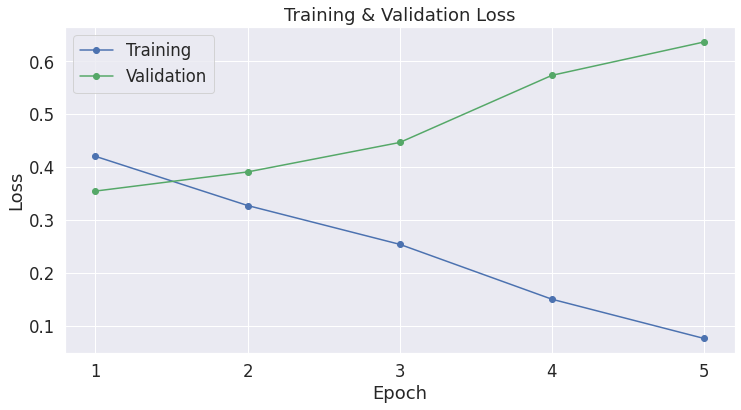

In [0]:
report_model_1(results_unbalanced)

In [0]:
results_balanced = train_val_gendermodel(train_loader=train_loader_balanced, val_loader=val_loader_balanced, epochs_val=5,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.55

Validation starts
  Accuracy: 0.80
  F1_score: 0.75
  Validation Loss: 0.43
===========Starting Epoch 2 / 5 ==============
Training starts

  Average training loss: 0.38

Validation starts
  Accuracy: 0.78
  F1_score: 0.78
  Validation Loss: 0.55
===========Starting Epoch 3 / 5 ==============
Training starts

  Average training loss: 0.26

Validation starts
  Accuracy: 0.81
  F1_score: 0.78
  Validation Loss: 0.55
===========Starting Epoch 4 / 5 ==============
Training starts

  Average training loss: 0.15

Validation starts
  Accuracy: 0.82
  F1_score: 0.79
  Validation Loss: 0.72
===========Starting Epoch 5 / 5 ==============
Training starts

  Average training loss: 0.09

Validation starts
  Accuracy: 0.82
  F1_score: 0.78
  Validation Loss: 0.79

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.550955  0.433793    0.795635  0.747124
2        0.378556  0.547196    0.781746  0.778285
3        0.260297  0.552497    0.809524  0.778522
4        0.151798  0.717036    0.815476  0.790137
5        0.091013  0.793537    0.817460  0.779646


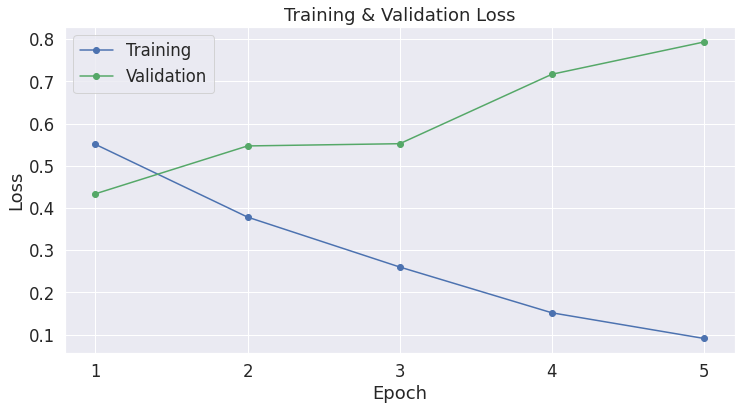

In [0]:
report_model_1(results_balanced)

In [0]:
results_balanced_split = train_val_gendermodel(train_loader=train_loader_balanced_split, val_loader=val_loader_balanced_split, epochs_val=5,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.52

Validation starts
  Accuracy: 0.79
  F1_score: 0.78
  Validation Loss: 0.44
===========Starting Epoch 2 / 5 ==============
Training starts

  Average training loss: 0.38

Validation starts
  Accuracy: 0.82
  F1_score: 0.79
  Validation Loss: 0.41
===========Starting Epoch 3 / 5 ==============
Training starts

  Average training loss: 0.26

Validation starts
  Accuracy: 0.84
  F1_score: 0.82
  Validation Loss: 0.54
===========Starting Epoch 4 / 5 ==============
Training starts

  Average training loss: 0.15

Validation starts
  Accuracy: 0.84
  F1_score: 0.82
  Validation Loss: 0.69
===========Starting Epoch 5 / 5 ==============
Training starts

  Average training loss: 0.07

Validation starts
  Accuracy: 0.84
  F1_score: 0.82
  Validation Loss: 0.80

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.516274  0.437157    0.789173  0.783864
2        0.381115  0.411396    0.821303  0.790070
3        0.264337  0.542285    0.838028  0.823471
4        0.153313  0.688070    0.843750  0.818131
5        0.070779  0.804654    0.844190  0.822824


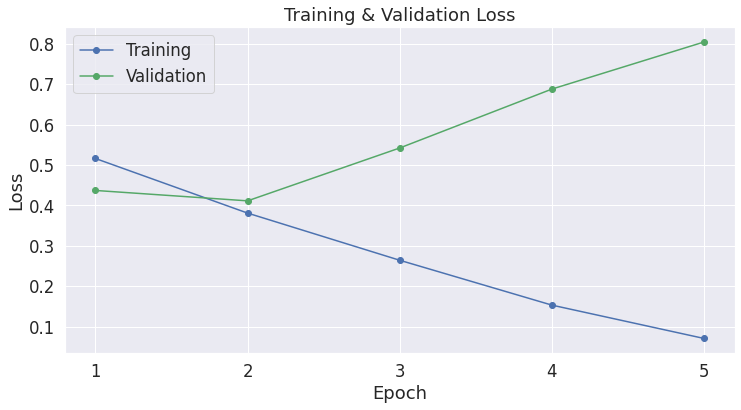

In [0]:
report_model_1(results_balanced_split)

### Training the optimal model 

In [215]:
df_eval= balanced_splitted(df,seed_val,frac_val=1,max_tokens=450)

Number of text in this balanced splitted corpus : 11,161

Proportions of women in the balanced splitted corpus : 50.22847415106173



In [0]:
# We prepare another sample which will be dedicated to further qualitative analysis

In [216]:
len_train = round(0.97*len(df_eval))
df_balanced_split= df_eval[0:len_train]
dev_balanced_split=df_eval[len_train:len(df_eval)]

# Report the number of speeches in the corpus.
print('Number of text in this balanced splitted corpus : {:,}\n'.format(df_balanced_split.shape[0]))
print('Number of text in the development sample : {:,}\n'.format(dev_balanced_split.shape[0]))

Number of text in this balanced splitted corpus : 10,826

Number of text in the development sample : 335



In [217]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced_split.Texte.values 
labels = df_balanced_split.sexe.values

torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
length = 500
batch_size_value = 16
length_train=0.9

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced_split = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced_split = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:   Il y a actuellement seulement 7400 VIE pour 40 000 demandes annuelles. Notre objectif est d'augment
IDs: tensor([    5,    69,   102,    33,  1344,   446,   333,  6877, 24426,    24,
          962,   624,  3083, 19492,     9,   785,  1739,    30,    18,    11,
         7878,    97,   365,     8,   618, 11091,   148,  2507,  2247,    72,
            7,    65,    49,    11,    41,    34,   424,  1182,    14,  1181,
           37,    19,  7070,     9,  6011,    26, 14177,     8,    13,   400,
         1636,     7,    31,    48, 10296,    29,  5798,   256,     7,    76,
           11,    73,  7191,   700,  1641,     8,   336,   147,   166,   699,
           56,    72, 19011,    43,   334,    48,  6874,   167,   334,   747,
           22,   285,    67,    44,    31, 22803,   194,    13,   957,   634,
         4680,    15,    13,   285,  2028,    67,   167,   334,    48,  7629])
Attention masks: tensor([1, 1, 1,

In [218]:

############################  IMPORT MODEL ################################################
from transformers import CamembertForSequenceClassification
gender_model = CamembertForSequenceClassification.from_pretrained("camembert-base", 
                                                                  num_labels = 2, 
                                                                  output_attentions = False, 
                                                                  output_hidden_states = False, )

gender_model.cuda()
############################## RANDOM SEED ##################################################

import random
seed=seed_val
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

############################### LEARNING RATE SCHEDULER #######################################

import torch.nn as nn
import torch.optim as optim
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = 3 

#Implements Adam algorithm with weight decay fix.
opti = AdamW(gender_model.parameters(),
              lr =5e-5, # learning rate (default = 1e-3)
              eps = 1e-8 # prevents division by 0 (default = 1e-8)
            )

num_training_steps = len(train_loader_balanced_split) * epochs

# Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
scheduler = get_linear_schedule_with_warmup(opti, 
                                            num_warmup_steps = 0,
                                            num_training_steps = num_training_steps)


for ep in range(0, epochs):
  print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
  print('Training starts')

  ################################### TRAINING ################################

  #Put the model in training mode
  gender_model.train()

  # Set the train loss for the epoch to 0 
  total_train_loss = 0

  for step, batch in enumerate(train_loader_balanced_split):
    # Clear gradients 
    gender_model.zero_grad() # 

    # Cpy the 3 batch to GPU 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    #return loss and logits
    loss, logits = gender_model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels) 
    
    # Accumulate training loss for all batches 
    total_train_loss += loss.item()

    #Backpropagating the gradients 
    loss.backward()

    # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
    torch.nn.utils.clip_grad_norm_(gender_model.parameters(), 1.0)

    # Update parameters 
    opti.step()

    # Update learning rate schedule
    scheduler.step()

  #Calculate the average training loss over all batches  
  avg_train_loss = total_train_loss / len(train_loader_balanced_split)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))

===========Starting Epoch 1 / 3 ==============
Training starts

  Average training loss: 0.49
===========Starting Epoch 2 / 3 ==============
Training starts

  Average training loss: 0.32
===========Starting Epoch 3 / 3 ==============
Training starts

  Average training loss: 0.20


In [0]:
torch.save( gender_model, 'gender_model_train.pt')

In [0]:
gender_model = torch.load('gender_model_train.pt')

Let's compute some statistics on the performance of this final model

In [0]:
 def evaluation_loop(model,eval_loader): 
  # Put model in evaluation mode 
  model.eval()
  total_eval_loss,total_pred,total_label,total_logits=[],[],[],[]

  for batch in eval_loader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad(): 
      loss, logits = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    #total_eval_loss += loss.item()

      # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      pred= np.argmax(logits, axis=1).flatten()
      labels_flat = label_ids.flatten()

    # Accumulation accuracy for all batch
      total_pred += pred.tolist()

    # Accumulation f1 for all batch
      total_label += labels_flat.tolist()

      # Logits score on positive 
      total_logits += logits.tolist()

  return total_pred,total_label,total_logits

In [0]:
total_pred,total_label,total_logits =evaluation_loop(gender_model,val_loader_balanced_split)

In [0]:
def model_report(pred,label,logits):
    """
        Input :
            pred : model prediction
        Output : 
            Classification_report + Confusion_matrix + ROC_curve + (si possible feature importance)
    """
    #from sklearn
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
    logits = [el[1] for el in total_logits]
    pred = [i for i in total_pred]
    label = [i for i in total_label]
    print ("Classification report :")
    print(classification_report(label,pred))
    print ("Accuracy : ",accuracy_score(label,pred))
    cm = confusion_matrix(label,pred)
    ROC = roc_auc_score(label,pred) 
    print ("AUC : ",ROC)
    fpr,tpr,thresholds = roc_curve(label,logits)
    plt.figure(figsize=(12,10))
    plt.subplot(221)
    sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues').set_title('Matrice de confusion')
    plt.subplot(222)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % ROC)
    plt.plot([0,1],[0,1],color='red')
    plt.title('Courbe ROC')
    plt.show()

Classification report :
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       526
           1       0.82      0.86      0.84       557

    accuracy                           0.83      1083
   macro avg       0.83      0.83      0.83      1083
weighted avg       0.83      0.83      0.83      1083

Accuracy :  0.8328716528162512
AUC :  0.8320203971575045


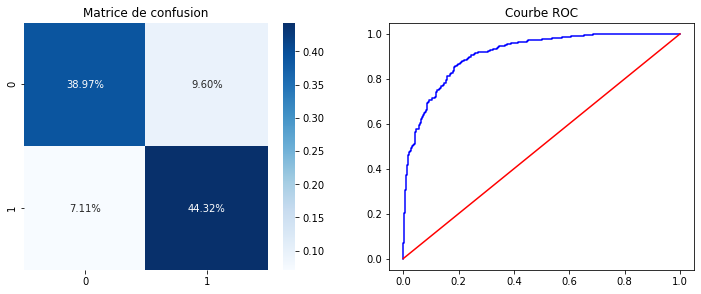

In [224]:
model_report(total_pred,total_label,logits)

## Evaluation and qualitative analysis 

Preparing development sequence 

We will use our development set we let outside of the analysis to make an attempt of qualitative analysis. 

In [225]:
# We prepare again the development sample for analysis 

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = dev_balanced_split.Texte.values
labels = dev_balanced_split.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            batch_size = 16, # Trains with this batch size.
            shuffle=False
        )

Let's check for the first text indexes, attention masks and labels
 
Original:   Et c'est bien là que se noue la question essentielle, à chaque instant présente : je veux parler du
IDs: tensor([    5,   139,    60,    11,    41,    72,   241,    27,    48, 28480,
           13,   397,  5626,     7,    15,   251,  3334,   679,    43,    50,
          920,   639,    25, 13495,     8,    13,   397,  4510,     9,   799,
           82, 25122, 29372,   106,   114,    23,   262,   804,     7,    29,
           23,  1917,    31,  6095,    14, 17400,    16,   256,     7, 19536,
           14,  1037, 11578,    19, 18684,    10,    25,  2370,     7,     8,
           13,  5280,    31,    82,  1860,    15,    13,   466,  1359,     8,
         2720,    14,    28,  8037,     7,     8,    17,    11, 21940,    15,
           13,   151, 28377,   141,    14, 31293,     7,    15,    44,   262,
           31,    33,   380,     7,    16,   532,   695,     7,    17,    11])
Attention masks: tensor([1, 1, 1,

In [0]:
# We make this development sample pass into the evaluation loop 
total_pred,total_labels,total_logits=evaluation_loop(gender_model,dev_dataloader)


In [0]:
def dev_treatment(total_pred,total_labels,total_logits,dev_balanced_split,df):
  # Extract the score for label 1 
  one_score = [el[1] for el in total_logits]
  max_score = np.max(total_logits,axis=1)

  # Put everything inside a dataframe
  results_dev=pd.DataFrame([total_labels,total_pred,one_score,max_score]).transpose()
  results_dev.columns=['returned_labels','model_pred','one_score','max_score']
  results_dev['WF']=pd.DataFrame([results_dev['model_pred']==results_dev['returned_labels']]).transpose()

  # Merge back with the text
  frames = [dev_balanced_split[['Texte','sexe','index_df']].reset_index(), results_dev]
  result = pd.concat(frames,axis=1)

  # We merge this dataframe to the information we had at the beginning
  merged_results=result[['index','index_df','Texte','returned_labels','model_pred','one_score','max_score','WF']].merge(df[['Titre','Id','Theme','Prenom','Nom','Date','Tags','sexe']],how='left',left_on='index_df',right_on='Id')

  return merged_results



In [0]:
result =  dev_treatment(total_pred,total_labels,total_logits,dev_balanced_split,df)

In [229]:
result.head()

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
0,10826,134631,Et c'est bien là que se noue la question esse...,1.0,1.0,1.427388,1.427388,True,"Déclaration de Mme Catherine Trautmann, minist...",134631,Institutions,Catherine,Trautmann,1998-01-11T12:00:00Z,"Justice - Droits fondamentaux,Antisémitisme",1
1,10827,170264,C'est un bonheur que de constater la richesse...,1.0,1.0,2.155089,2.155089,True,"Déclaration de Mme Roselyne Bachelot, ministre...",170264,Société,Roselyne,Bachelot-Narquin,2007-12-11T12:00:00Z,"Société - Population,Personne âgée",1
2,10828,192891,M. Roland Courteau. Très bien ! Mme Carole De...,1.0,1.0,2.370206,2.370206,True,"Déclaration de MMe Carole Delga, secrétaire d'...",192891,Economie,Carole,Delga,2014-10-21T12:00:00Z,"Vie économique,Politique économique",1
3,10829,177095,Mais la crise a bouleversé tous les repères. ...,1.0,1.0,0.766086,0.766086,True,"Déclaration de Mme Christine Lagarde, ministre...",177095,Economie,Christine,Lagarde,2009-10-20T12:00:00Z,"Finances publiques,Budget de l'Etat",1
4,10830,144772,"Mesdames, Messieurs, j'ai souhaité, vous le s...",0.0,0.0,-1.947491,1.946521,True,"Déclaration de M. Jean-François Mattei, minist...",144772,Société,Jean-François,Mattei,2003-12-10T12:00:00Z,"Santé - Protection sociale,Santé publique",0


In [230]:
#Which texts failed ? 
print('{0:.2f} percent of the development texts were not well classified by our model'.format(result[result.WF==False].WF.count()*100/len(result)))

12.54 percent of the development texts were not well classified by our model


Now we are going to take 3 text well classified and 3 other wrongly classified. We will try to take the ones the model is really sure about in the good or bad side.

In [0]:
top_texts_true=result[result.WF==1].nlargest(3,'max_score')
top_texts_false=result[result.WF==0].nlargest(3,'max_score')

In [232]:
top_texts_true

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
147,10973,140199,Je ne suis pas toujours d'accord avec monsieu...,0.0,0.0,-2.588010,2.579525,True,"Déclaration de M. Jean-Pierre Raffarin, Premie...",140199,International,Jean-Pierre,Raffarin,2003-10-06T12:00:00Z,"Relations internationales,Relations bilatérale...",0
44,10870,134262,"J'ai confiance, car je connais la vitalité et...",0.0,0.0,-2.591268,2.575959,True,"Discours de M. Jacques Chirac, Président de la...",134262,"International,Société",Jacques,Chirac,1997-03-17T12:00:00Z,"Relations internationales,Relations bilatérale...",0
240,11066,142205,La première de ces pistes concerne les perspe...,0.0,0.0,-2.577943,2.570937,True,"Déclaration de M. Jean-Pierre Raffarin, Premie...",142205,NaN,Jean-Pierre,Raffarin,2003-12-01T12:00:00Z,NaN,0


In [233]:
top_texts_false

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
186,11012,180950,"Messieurs les ministres,Madame la présidente,...",1.0,0.0,-2.295846,2.318840,False,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1
171,10997,167570,Je viens d'apprendre avec soulagement que le ...,1.0,0.0,-2.191277,2.169469,False,"Déclaration de Mme Rama Yade, secrétaire d'Eta...",167570,Institutions,Rama,Yade,2007-08-30T12:00:00Z,"Justice - Droits fondamentaux,Peine",1
120,10946,144150,"Ensuite il s'étonne : "" Pourtant, écrit-il, i...",1.0,0.0,-2.057754,2.138344,False,"Déclaration de Mme Marine Le Pen, vice-préside...",144150,Institutions,Marine,Le Pen,2003-11-08T12:00:00Z,"Citoyenneté - Elections,Parti politique",1


We want to dive a bit into the model and see how it makes a choice and why it fails to recognize the denger of the speaker on these sentences . Let's take one of them. We will redo point 4 of TD4 to see the score reached by each word. 

In [0]:
def split_document_to_limit_phrases(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = ''
    for phrases in sent_detector_mano(row.Texte):
      if len(phrase.split(' ')) + len(phrases.split(' ')) < MAX_TOKENS:
        phrase+= " " + phrases
      else:
        lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
        phrase = ''
    lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
    phrase = ''
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])

In [0]:
sentence_to_analyse = pd.concat([top_texts_false,top_texts_true]).reset_index(drop=True)
sentence_to_analyse=split_document_to_limit_phrases(50,sentence_to_analyse)
sentence_to_analyse=sentence_to_analyse[sentence_to_analyse.Texte!='']

In [236]:
max(sentence_to_analyse.Length)

49

In [237]:
sentence_to_analyse.Texte

0      Messieurs les ministres,Madame la présidente,...
1      Voilà donc la quatrième édition des voeux que...
3      Ce n'est donc pas le moment de fléchir et c'e...
4      Je continuerai donc à promouvoir l'assainisse...
5      une raison morale. C'est une question de just...
6      Son effet sur la croissance moyenne de la déc...
8      Je viens d'apprendre avec soulagement que le ...
9      Agé de 30 ans, Kenneth Foster a en effet été ...
10     Depuis, je suivais l'affaire jour après jour....
11     Je soutiendrai toute initiative allant dans c...
13     Ensuite il s'étonne : " Pourtant, écrit-il, i...
14     Les promesses passent, Jacques Chirac demeure...
15     Il existe depuis 1950 et permet la mise en pl...
16     On comprend alors d'autant moins la deuxième ...
17     Je ne voudrais pas faire injure à M. Copé de ...
18     Allez Clotaire. . . rendors-toi ! M. Copé se ...
19     Copé réussirait donc à faire en Ile-de-France...
20     + 2 % et encore ne s'agit-il que des stat

In [238]:
# We prepare again the development sample for analysis 

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = sentence_to_analyse.Texte.values
labels = sentence_to_analyse.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 60,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            batch_size = 1, # Trains with this batch size.
            shuffle=False
        )

Let's check for the first text indexes, attention masks and labels
 
Original:   Messieurs les ministres,Madame la présidente, chère Françoise CROUIGNEAU,Mesdames, Messieurs les jo
IDs: tensor([    5, 19923,    19,  7427,     7,  3181,  9402,    35,    13,  8092,
            7,  5804, 10594,    84, 22714, 10467, 12974,     7,  6684,    10,
         9402,    80,     7, 19923,    19,  4451,     7,   452,  9890,  3554,
         3515,    27,   831,    13,  1197,   149,    28,  5399,    25,   823,
            9,   683,  1831,    72,   705,    24,    19,   389,    14,    19,
          529,  1204,    67, 12041,    27,    17,    11,    88, 12155,     6])
Attention masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
labels tensor(1)


In [0]:
total_pred,total_labels,total_logits =evaluation_loop(gender_model,dev_dataloader)

In [0]:
result =  dev_treatment(total_pred,total_labels,total_logits,sentence_to_analyse,df)

In [241]:
result.head()

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
0,0,180950,"Messieurs les ministres,Madame la présidente,...",1.0,0.0,-1.700761,1.743103,False,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1
1,1,180950,Voilà donc la quatrième édition des voeux que...,1.0,1.0,0.137415,0.137415,True,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1
2,3,180950,Ce n'est donc pas le moment de fléchir et c'e...,1.0,1.0,0.869216,0.869216,True,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1
3,4,180950,Je continuerai donc à promouvoir l'assainisse...,1.0,0.0,-0.501634,0.596974,False,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1
4,5,180950,une raison morale. C'est une question de just...,1.0,0.0,-0.503998,0.593478,False,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1


In [242]:
#Which sentences failed ? 
print('{0:.2f} percent of the development texts were not well classified by our model'.format(result[result.WF==False].WF.count()*100/len(result)))

41.67 percent of the development texts were not well classified by our model


In [0]:
top_sentence_true=result[result.WF==1].nlargest(1,'max_score')
top_sentence_false=result[result.WF==0].nlargest(1,'max_score')

In [244]:
top_sentence_false

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
14,17,144150,Je ne voudrais pas faire injure à M. Copé de ...,1.0,0.0,-2.026643,2.11228,False,"Déclaration de Mme Marine Le Pen, vice-préside...",144150,Institutions,Marine,Le Pen,2003-11-08T12:00:00Z,"Citoyenneté - Elections,Parti politique",1


In [245]:
top_sentence_true

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
32,38,142205,Je pense notamment donc aux grands travaux d'...,0.0,0.0,-2.565085,2.541824,True,"Déclaration de M. Jean-Pierre Raffarin, Premie...",142205,NaN,Jean-Pierre,Raffarin,2003-12-01T12:00:00Z,NaN,0


In [0]:
words_to_analyse = pd.concat([top_sentence_false,top_sentence_true]).reset_index(drop=True)

In [0]:
lst= []
for index,row in words_to_analyse.iterrows():
  identifiant = row.index_df
  label = row.sexe
  phrase = []
  for token in row.Texte.split(' '):
      lst += [(identifiant,label,token)]

In [0]:
words_to_analyse=pd.DataFrame(lst,columns=['index_df','sexe','Texte'])

In [249]:
words_to_analyse=words_to_analyse[words_to_analyse.Texte!='']
words_to_analyse.head()

,index_df,sexe,Texte
1,144150,1,Je
2,144150,1,ne
3,144150,1,voudrais
4,144150,1,pas
5,144150,1,faire


In [250]:
# We prepare again the development sample for analysis 

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = words_to_analyse.Texte.values
labels = words_to_analyse.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 5,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            batch_size = 1, # Trains with this batch size.
            shuffle=False
        )

Let's check for the first text indexes, attention masks and labels
 
Original:  Je
IDs: tensor([  5, 100,   6,   1,   1])
Attention masks: tensor([1, 1, 1, 0, 0])
labels tensor(1)


In [0]:
total_pred,total_labels,total_logits =evaluation_loop(gender_model,dev_dataloader)

In [0]:
# Extract the score for label 1 
one_score = [el[1] for el in total_logits]
max_score = np.max(total_logits,axis=1)
# Put everything inside a dataframe
results_dev=pd.DataFrame([total_labels,total_pred,one_score,max_score]).transpose()
results_dev.columns=['returned_labels','model_pred','one_score','max_score']
results_dev['WF']=pd.DataFrame([results_dev['model_pred']==results_dev['returned_labels']]).transpose()
# Merge back with the text
frames = [words_to_analyse[['Texte','sexe','index_df']].reset_index(), results_dev]
result = pd.concat(frames,axis=1)

In [253]:
result

,index,Texte,sexe,index_df,returned_labels,model_pred,one_score,max_score,WF
0,1,Je,1,144150,1.0,1.0,0.349091,0.349091,True
1,2,ne,1,144150,1.0,0.0,-0.426278,0.561712,False
2,3,voudrais,1,144150,1.0,0.0,-0.187749,0.350115,False
3,4,pas,1,144150,1.0,0.0,-0.776480,0.888025,False
4,5,faire,1,144150,1.0,0.0,-1.165817,1.199890,False
...,...,...,...,...,...,...,...,...,...
75,77,étroite,0,142205,0.0,0.0,0.044067,0.126024,True
76,78,entre,0,142205,0.0,0.0,-0.558972,0.719967,True
77,79,nos,0,142205,0.0,0.0,-0.519215,0.598572,True
78,80,deux,0,142205,0.0,0.0,-0.407309,0.580043,True


In [0]:
scores_false = [i for i in result[result.index_df==144150].one_score]
df_plot_false=pd.DataFrame(scores_false).transpose()
df_plot_false.columns=list(result[result.index_df==144150].Texte)

In [261]:
df_plot_false

,Je,ne,voudrais,pas,faire,injure,à,M.,Copé,de,l'accuser,de,manquer,de,"discernement,",mais,je,ne,vois,pas,pourquoi,les,Franciliens,seraient,différents,des,autres,Français,qui,attendent,tous,des,"résultats,",et,cela,depuis,des,lustres,!,M.
0,0.349091,-0.426278,-0.187749,-0.77648,-1.165817,-1.691139,-0.71642,-0.447855,-1.2476,-0.424134,-0.20748,-0.424134,-0.323482,-0.424134,-0.609333,-0.327148,-0.186833,-0.426278,-0.155829,-0.77648,-0.191955,-0.30145,-1.85175,-0.337622,-0.752942,-0.190658,-0.258925,-0.967783,-1.090493,-0.261131,-0.857057,-0.190658,-0.377658,-0.357567,-1.289638,-0.615005,-0.190658,0.341504,-0.895928,-0.447855


In [0]:
scores_true = [i for i in result[result.index_df==142205].one_score]
df_plot_true=pd.DataFrame(scores_true).transpose()
df_plot_true.columns=list(result[result.index_df==142205].Texte)

In [263]:
df_plot_true

,Je,pense,notamment,donc,aux,grands,travaux,d'infrastructure.,La,conjugaison,de,l'expérience,française,et,les,besoins,considérables,de,la,Pologne,et,ses,capacités,ouvrent,la,"porte,",j'en,suis,"certain,",à,une,collaboration,et,une,concertation,étroite,entre,nos,deux,pays.
0,0.349091,-0.135004,-0.413207,-1.260916,-0.509232,-0.832283,-0.185379,-1.021046,-0.059596,-0.262412,-0.424134,-0.062031,-0.04669,-0.357567,-0.30145,-0.051739,-0.8368,-0.424134,-0.492656,-0.208911,-0.357567,-0.405813,0.157385,-0.351969,-0.492656,-0.893208,0.590052,-0.04247,-1.929725,-0.71642,-0.17469,0.139364,-0.357567,-0.17469,-0.455318,0.044067,-0.558972,-0.519215,-0.407309,-0.916333


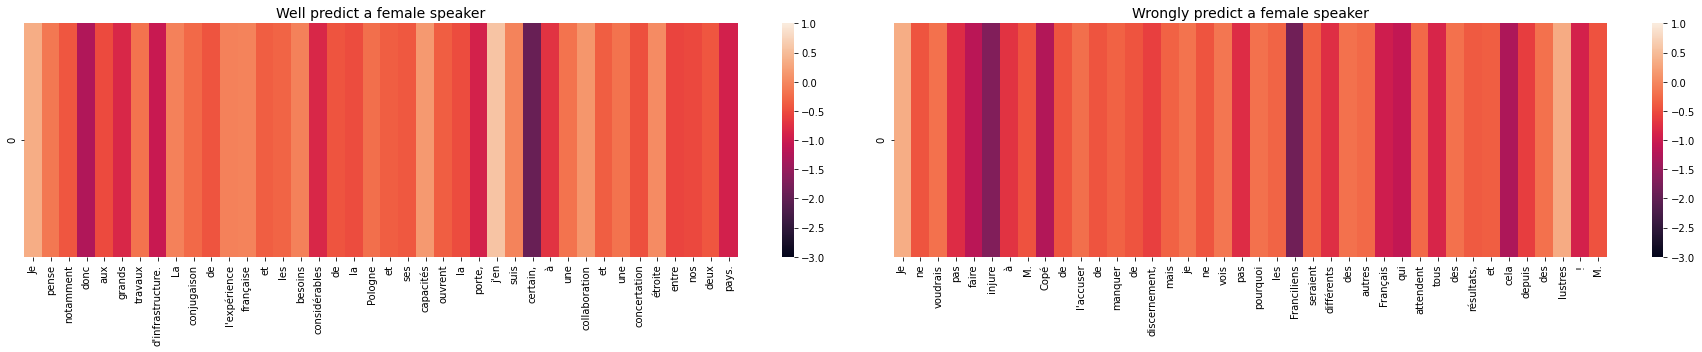

In [266]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,5))

#  heatmap - female subplot
fig.add_subplot(121)
plt.title('Well predict a female speaker', fontsize=14)
sns.heatmap(df_plot_true, annot=False, fmt='.2f',vmin=-3,vmax=1)

#  heatmap - male subplot
fig.add_subplot(122)
plt.title('Wrongly predict a female speaker', fontsize=14)
sns.heatmap(df_plot_false, annot=False, fmt='.2f',vmin=-3,vmax=1 )

fig.tight_layout()
plt.show()


In [0]:


cbar_ax = fig.add_axes([.91,.3,.03,.4])
sns.heatmap(pd1.corr(),ax=ax0,cbar=True,vmin=-1,vmax=1,cbar_ax = cbar_ax)
ax0.set_title('title1')
sns.heatmap(pd2.corr(),ax=ax1,cbar=True,vmin=-1,vmax=1,cbar_ax = cbar_ax)
ax1.set_title('title 2')
fig.suptitle('big title',fontsize=20)
#saving figure for publication if needed
plt.savefig('save.tif', dpi=300)
plt.show()
cbar_ax = fig.add_axes([.91,.3,.03,.4])



ValueError: ignored

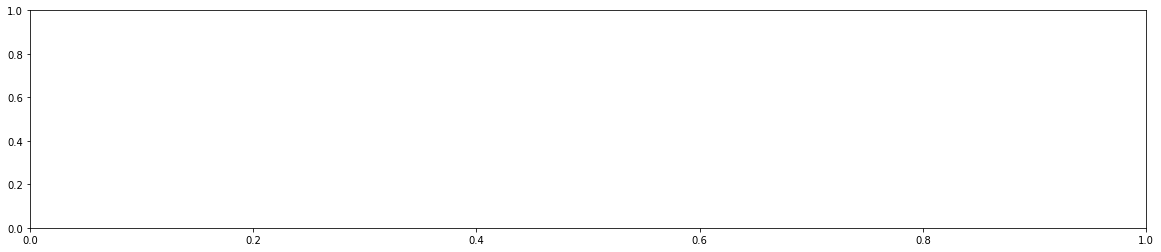

In [153]:

fig, ax = plt.subplots(figsize=(20,4)) 
sns.heatmap(df_plot_true)
plt.show()


Faire des annotations pour la fin du doc et nettoyer mettre en forme
Faire des fonctions pour la fin 
Amélioer le graphique . Est ce que c'est intelligent par mot ? 
Remplacer score max par la moyenne des logits à chercher à la fin du train 
Analyser un peu et mettre au propre sur la feuille


# Test 

,index,index_df,sexe,Texte,Length
0,8844,163979,0,163979,444
1,3971,192898,1,192898,443
2,1813,191962,1,191962,439
3,2254,147466,1,147466,403
4,1704,173140,1,173140,419
...,...,...,...,...,...
11192,3655,175003,1,175003,208
11193,1661,180667,1,180667,429
11194,2139,205519,1,205519,229
11195,7491,185081,0,185081,428


In [0]:
# Import Camembert tokenizer
from transformers import CamembertTokenizer
# We choose a right padding side for the moment and we will test for a left padding side on a second stage
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right') #left

In [0]:

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced_split.Texte.values
labels = df_balanced_split.sexe.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])


# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = 16

# We create data loaders for the train and validation dataset. 
train_dataloader = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_dataloader = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  la spécialisation des navires ; un nombre supérieur de moyens d'observation, de communication et de 
IDs: tensor([    5,    13, 20831,    20, 11013,   167,    23,   365,  2062,     8,
         1149,    18,    11,  7064,     7,     8,  1006,    14,     8,  9888,
          167,     8,   704,  1979,    18,    11,  7781,   167,    20,  3768,
           18,    11,  3064, 12914, 17441, 19963,    80,    24,    98,    22,
          586,    18,    11,  4976,  6916,    36,   731,     8, 12463,    10,
            7,    22,    21, 14319,    17,    11,   649,    20,   592, 10424,
           37,    19,   678, 13957,     8,  1983, 16111,   167,    13,  2966,
            7,   743,     7,    18,    11,  2688,    13,  9157,   128,    20,
        11013,    14,  1979,    18,    11,  7781,  4993,    14,    18,    11,
          266,    40,  2294,     7,    66,    22, 26634,   172,    16,  1984])
Attention masks: tensor([1, 1, 1,

In [0]:
results_unbalanced = train_val_gendermodel(train_loader=train_dataloader, val_loader=val_dataloader, epochs_val=5,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.51

Validation starts
  Accuracy: 0.80
  F1_score: 0.80
  Validation Loss: 0.43
===========Starting Epoch 2 / 5 ==============
Training starts

  Average training loss: 0.36

Validation starts
  Accuracy: 0.82
  F1_score: 0.81
  Validation Loss: 0.41
===========Starting Epoch 3 / 5 ==============
Training starts

  Average training loss: 0.23

Validation starts
  Accuracy: 0.84
  F1_score: 0.83
  Validation Loss: 0.49
===========Starting Epoch 4 / 5 ==============
Training starts

  Average training loss: 0.13

Validation starts
  Accuracy: 0.83
  F1_score: 0.83
  Validation Loss: 0.66
===========Starting Epoch 5 / 5 ==============
Training starts

  Average training loss: 0.06

Validation starts
  Accuracy: 0.82
  F1_score: 0.81
  Validation Loss: 0.79

Done !


       Train Loss  Val Loss  Val Accur.    Val F1
epoch                                            
1        0.506192  0.425347    0.798632  0.800964
2        0.359642  0.408357    0.819022  0.813722
3        0.229572  0.491328    0.836753  0.833890
4        0.132649  0.656070    0.827001  0.826271
5        0.060629  0.793369    0.823582  0.813131


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


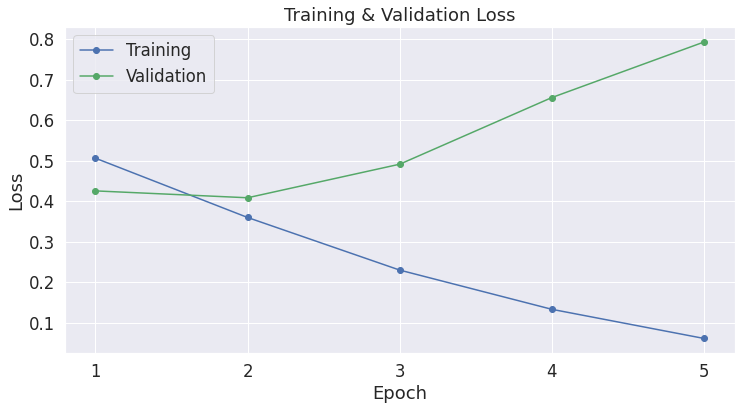

In [0]:
report_model_1(results_unbalanced)

In [0]:
############################  IMPORT MODEL ################################################
from transformers import CamembertForSequenceClassification
gender_model = CamembertForSequenceClassification.from_pretrained(
  "camembert-base", 
  num_labels = 2, # We have two different labels Women = 1 and Men =0   
  output_attentions = False, 
  output_hidden_states = False, )

model = gender_model
model.cuda()

lr_value = 5e-5
train_loader=train_dataloader
val_loader=val_dataloader
epochs_val=3
seed_val=2020
device=device
lr_value=5e-5

############################## RANDOM SEED ##################################################

import random
# Let's put a seed to make this result reproducible 
seed=seed_val
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

############################### LEARNING RATE SCHEDULER #######################################

# https://huggingface.co/transformers/migration.html 
# https://pytorch.org/docs/stable/optim.html (default values)

import torch.nn as nn
import torch.optim as optim
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = epochs_val # In order to fine tune our model we will first set the number of epochs to 4.

# We choose Binary cross enthropy with logits loss for the loss computation. It seems to be the most adapted loss to our problem. 
criterion = nn.BCEWithLogitsLoss()
#Implements Adam algorithm with weight decay fix.
opti = AdamW(model.parameters(),
                  lr =lr_value, # learning rate (default = 1e-3)
                  eps = 1e-8 # prevents division by 0 (default = 1e-8)
                )

num_training_steps = len(train_loader) * epochs
# Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
scheduler = get_linear_schedule_with_warmup(opti, 
                                            num_warmup_steps = 0,
                                            num_training_steps = num_training_steps)


# We want to evaluate the training phase 
training_stats = []

for ep in range(0, epochs):
  print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
  print('Training starts')

  ################################### TRAINING ################################

  #Put the model in training mode
  model.train()

  # Set the train loss for the epoch to 0 
  total_train_loss = 0

  for step, batch in enumerate(train_loader):
    # Clear gradients 
    model.zero_grad() # (opti.zerograd ? )

    # Cpy the 3 batch to GPU 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    #return loss and logits
    loss, logits = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels) 
    
    # Accumulate training loss for all batches 
    total_train_loss += loss.item()

    #Backpropagating the gradients 
    loss.backward()

    # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters 
    opti.step()

    # Update learning rate schedule
    scheduler.step()

  #Calculate the average training loss over all batches  
  avg_train_loss = total_train_loss / len(train_loader)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print('')
  print('Validation starts')

  ###################### VALIDATION #############################

  # Put model in evaluation mode 
  model.eval()

  # Set statistics to 0
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  total_eval_f1=0
  total_roc_auc = 0 

  # Confusion matrix ?
  predictions, true_labels = [], []

  for batch in val_loader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # We don't care about gradients for eval

    with torch.no_grad(): 
      (loss, logits) = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    total_eval_loss += loss.item()

      # Move logits and labels to CPU 
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    F1_score, Accuracy = create_report(label_ids,logits)

    # Accumulation accuracy for all batch
    total_eval_accuracy += Accuracy

    # Accumulation f1 for all batch
    total_eval_f1 += F1_score
    
    #Final accuracy on all batch
  avg_val_accuracy = total_eval_accuracy / len(val_loader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))


    #Final f1 on all batch
  avg_val_f1 = total_eval_f1 / len(val_loader)
  print("  F1_score: {0:.2f}".format(avg_val_f1))

    #Final loss over all batch
  avg_val_loss = total_eval_loss / len(val_loader)
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))

  training_stats.append(
        {
            'epoch': ep + 1,
            'Train Loss': avg_train_loss,
            'Val Loss': avg_val_loss,
            'Val Accur.': avg_val_accuracy,
            'Val F1' : avg_val_f1,
        }
    )

print("")
print("Done !")

===========Starting Epoch 1 / 3 ==============
Training starts

  Average training loss: 0.51

Validation starts
  Accuracy: 0.85
  F1_score: 0.52
  Validation Loss: 0.43
===========Starting Epoch 2 / 3 ==============
Training starts

  Average training loss: 0.36

Validation starts
  Accuracy: 0.86
  F1_score: 0.62
  Validation Loss: 0.34
===========Starting Epoch 3 / 3 ==============
Training starts

  Average training loss: 0.27

Validation starts
  Accuracy: 0.83
  F1_score: 0.61
  Validation Loss: 0.40

Done !


       Train Loss  Val Loss  Val Accur.    Val F1  accur 2 
epoch                                                      
1        0.486057  0.393362      0.8500  0.502009    0.8500
2        0.340707  0.359600      0.8525  0.507469    0.8525
3        0.244166  0.372269      0.8650  0.637284    0.8650


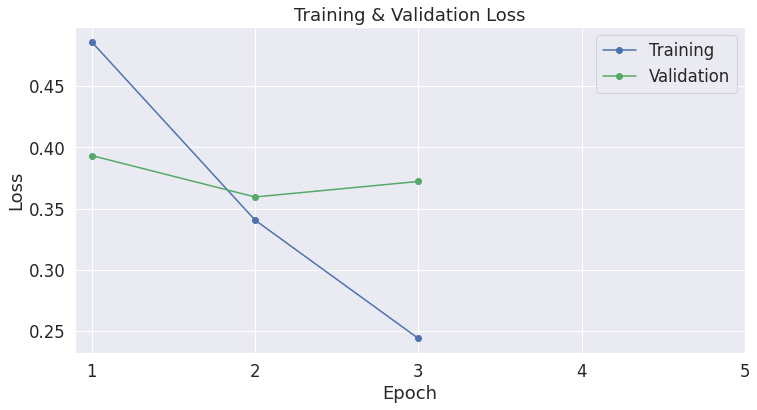

In [0]:
report_model_1(results_unbalanced)

In [0]:
results_unbalanced = train_val_gendermodel(train_loader=train_loader_unbalanced, val_loader=val_loader_unbalanced, epochs_val=3,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 3 ==============
Training starts

  Average training loss: 0.65

Validation starts
  Accuracy: 0.76
  Accuracy: 0.76
  F1_score: 0.60
  Validation Loss: 0.60
===========Starting Epoch 2 / 3 ==============
Training starts

  Average training loss: 0.66

Validation starts
  Accuracy: 0.76
  Accuracy: 0.76
  F1_score: 0.60
  Validation Loss: 0.65
===========Starting Epoch 3 / 3 ==============
Training starts

  Average training loss: 0.66

Validation starts
  Accuracy: 0.76
  Accuracy: 0.76
  F1_score: 0.60
  Validation Loss: 0.61

Done !


In [0]:
PROBLEM DANS LE LOAD 

In [0]:

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df.Texte.values
labels = df.sexe.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

NameError: ignored

In [0]:
# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_dataloader = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_dataloader = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')



In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df.Texte.values
labels = df.sexe.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])


NameError: ignored